
# Experiment 4:	Hyper-parameter tuning for a BPNN




### **1. Objective**
WAP to evaluate the performance of implemented three-layer neural network with variations in activation functions, size of hidden layer, learning rate, batch size and number of epochs.


### **2. Description of the Model**
This model is a simple **feedforward neural network (FNN)** and **backpropagation  neural network(BPNN)** designed for classifying handwritten digits from the **MNIST dataset**. The architecture consists of:
- **Input Layer**: 784 neurons (flattened 28×28 grayscale images)
- **Hidden Layer 1** and **Hidden Layer 2**: are varied in range [(160, 100), (100, 100), (100, 160), (60, 60), (100, 60)] with activation function as Relu
- **Output Layer**: 10 neurons (one for each digit 0-9), using raw logits
- **Learning Rate**:is also varied between [0.01, 0.1, 1]
- **Loss Function**: Softmax cross-entropy
- **Optimizer**: Adam Optimizer
- **Performance Metric**: Accuracy,loss curves, confusion matrix

The model is trained for **50 epochs** with batch size = 10.

### **3. Python Implementation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install & Import Dependencies

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pandas as pd
import json
from sklearn.metrics import confusion_matrix

# Disable eager execution for TF 2.x compatibility with TF 1.x code
tf.compat.v1.disable_eager_execution()

# Load MNIST dataset
mnist_data = tfds.load("mnist", as_supervised=True)
train_data, test_data = mnist_data["train"], mnist_data["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.30XBMI_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.30XBMI_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Load & Preprocess MNIST Dataset

In [3]:

# Preprocess function: Flatten and Normalize
def preprocess(image, label):
    image = tf.reshape(image, [-1])  # Flatten (28x28 → 784)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize (0-255 → 0-1)
    label = tf.one_hot(label, depth=10)  # One-hot encode
    return image, label

# Training parameters
batch_size = 10
num_epochs = 50
steps_per_epoch = 60000 // batch_size  # MNIST has 60,000 training images

# Apply preprocessing, shuffle, and batch
train_data = train_data.map(preprocess).shuffle(10000).batch(batch_size)
test_data = test_data.map(preprocess).batch(batch_size)

# Define placeholders
X = tf.compat.v1.placeholder(tf.float32, shape=[None, 784])
Y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])



In [4]:
# Store results
results = []
time_records = []
accuracy_curves = {}
loss_curves = {}
confusion_matrices = {}

hidden_layer_configs = [(160, 100), (100, 100), (100, 160)]
learning_rates = [0.01, 0.1, 1]

In [5]:
# Define network parameters
def create_network(h1, h2):
    weights = {
        "h1": tf.Variable(tf.random.normal([784, h1])),
        "h2": tf.Variable(tf.random.normal([h1, h2])),
        "out": tf.Variable(tf.random.normal([h2, 10])),
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([h1])),
        "b2": tf.Variable(tf.random.normal([h2])),
        "out": tf.Variable(tf.random.normal([10])),
    }
    return weights, biases


In [6]:
# Define forward propagation function
def forward_propagation(x, weights, biases):
    layer1 = tf.nn.relu(tf.add(tf.matmul(x, weights["h1"]), biases["b1"]))
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, weights["h2"]), biases["b2"]))
    output_layer = tf.add(tf.matmul(layer2, weights["out"]), biases["out"])
    return output_layer


Training first 9 configuration of hidden_layer_configs = [(160, 100), (100, 100), (100, 160)] and learning_rates = [0.01, 0.1, 1]

In [8]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))

            # Save results after each configuration
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/accuracy_curves_final1.npy", accuracy_curves)
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/loss_curves_final1.npy", loss_curves)
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/confusion_matrices_final1.npy", confusion_matrices)
            with open("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/results_final1.json", "w") as f:
                json.dump(results, f)

Training with hidden layers (160, 100) and learning rate 0.01
Epoch 1, Loss: 7.6674, Accuracy: 78.40%
Epoch 2, Loss: 0.5999, Accuracy: 86.78%
Epoch 3, Loss: 0.5451, Accuracy: 87.85%
Epoch 4, Loss: 0.4794, Accuracy: 90.07%
Epoch 5, Loss: 0.4776, Accuracy: 90.39%
Epoch 6, Loss: 0.4418, Accuracy: 91.46%
Epoch 7, Loss: 0.5187, Accuracy: 90.09%
Epoch 8, Loss: 0.4989, Accuracy: 90.21%
Epoch 9, Loss: 0.5009, Accuracy: 90.28%
Epoch 10, Loss: 0.5135, Accuracy: 89.24%
Epoch 11, Loss: 0.4950, Accuracy: 89.87%
Epoch 12, Loss: 0.5263, Accuracy: 89.31%
Epoch 13, Loss: 0.5447, Accuracy: 88.71%
Epoch 14, Loss: 0.5273, Accuracy: 88.77%
Epoch 15, Loss: 0.5718, Accuracy: 87.86%
Epoch 16, Loss: 0.5344, Accuracy: 88.34%
Epoch 17, Loss: 0.5831, Accuracy: 88.31%
Epoch 18, Loss: 0.5920, Accuracy: 87.84%
Epoch 19, Loss: 0.6608, Accuracy: 85.92%
Epoch 20, Loss: 0.6900, Accuracy: 84.53%
Epoch 21, Loss: 0.8204, Accuracy: 84.03%
Epoch 22, Loss: 0.7070, Accuracy: 83.87%
Epoch 23, Loss: 0.7968, Accuracy: 80.71%
Epoc

Training remaining 6 configuration with hidden_layer_configs = [(60, 60), (100, 60)] and learning_rates = [0.01, 0.1, 1]

In [9]:
hidden_layer_configs = [(60, 60), (100, 60)]
learning_rates = [0.01, 0.1, 1]
results=[]

In [10]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))

            # Save results after each configuration
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/confusion_matrices_last2.npy", accuracy_curves)
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/loss_curves_last2.npy", loss_curves)
            np.save("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/confusion_matrices_last2.npy", confusion_matrices)
            with open("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/results_last2.json", "w") as f:
                json.dump(results, f)

Training with hidden layers (60, 60) and learning rate 0.01
Epoch 1, Loss: 3.5050, Accuracy: 77.08%
Epoch 2, Loss: 0.4016, Accuracy: 89.70%
Epoch 3, Loss: 0.3074, Accuracy: 92.43%
Epoch 4, Loss: 0.2900, Accuracy: 93.09%
Epoch 5, Loss: 0.2673, Accuracy: 93.82%
Epoch 6, Loss: 0.2521, Accuracy: 94.18%
Epoch 7, Loss: 0.2476, Accuracy: 94.16%
Epoch 8, Loss: 0.2452, Accuracy: 94.31%
Epoch 9, Loss: 0.2381, Accuracy: 94.51%
Epoch 10, Loss: 0.2317, Accuracy: 94.61%
Epoch 11, Loss: 0.2335, Accuracy: 94.71%
Epoch 12, Loss: 0.2354, Accuracy: 94.60%
Epoch 13, Loss: 0.2252, Accuracy: 94.67%
Epoch 14, Loss: 0.2315, Accuracy: 94.79%
Epoch 15, Loss: 0.2234, Accuracy: 94.71%
Epoch 16, Loss: 0.2396, Accuracy: 94.45%
Epoch 17, Loss: 0.2164, Accuracy: 94.62%
Epoch 18, Loss: 0.2231, Accuracy: 94.84%
Epoch 19, Loss: 0.2452, Accuracy: 94.19%
Epoch 20, Loss: 0.2436, Accuracy: 94.38%
Epoch 21, Loss: 0.2554, Accuracy: 94.34%
Epoch 22, Loss: 0.2387, Accuracy: 94.31%
Epoch 23, Loss: 0.2355, Accuracy: 94.33%
Epoch 

### **4.Description of Code**
The experiment is implemented using TensorFlow 1.x compatibility mode in TensorFlow 2.x. Key components include:
1. **Data Preprocessing:**
   - Loading MNIST dataset via `tensorflow_datasets`
   - `mnist_data = tfds.load("mnist", as_supervised=True)` loads the dataset.
   - Flattening images and normalizing pixel values to [0,1]
   - `preprocess(image, label)` function flattens images and normalizes pixel values
   - One-hot encoding labels
   
2. **Model Definition:**
  - `forward_propagation(x)` applies Relu activation for hidden layers.
   - Using placeholders for input (`X`) and output (`Y`)
   - Initializing weights and biases for different hidden layer configurations
   - Implementing forward propagation with Relu activation
3. **Training Setup:**
   - Defining loss using `softmax_cross_entropy_with_logits`
   - Optimizing using `AdamOptimizer`
   - Evaluating accuracy using `tf.equal` and `tf.reduce_mean`
4. **Hyperparameter Tuning:**
   - Looping over different hidden layer configurations and learning rates
   - Storing results for analysis
5. **Performance Evaluation:**
   - Calculating training and test accuracy
  - Computes test accuracy using `tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))`.
   - Plotting accuracy/loss curves
   - Computing the confusion matrix


### **5.Performance Evaluation**

In [11]:
# Load saved results

import numpy as np
import json
accuracy_curves = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/accuracy_curves_final1.npy", allow_pickle=True).item()
accuracy_curves2 = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/accuracy_curves_last2.npy", allow_pickle=True).item()
accuracy_curves.update(accuracy_curves2)

loss_curves = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/loss_curves_final1.npy", allow_pickle=True).item()
loss_curves2 = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/loss_curves_last2.npy", allow_pickle=True).item()
loss_curves.update(loss_curves2)

confusion_matrices = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/confusion_matrices_final1.npy", allow_pickle=True).item()
confusion_matrices2 = np.load("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/confusion_matrices_last2.npy", allow_pickle=True).item()
confusion_matrices.update(confusion_matrices2)


with open("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/exp4_output/results_final1.json", "r") as f:
        results = json.load(f)
with open("/content/drive/MyDrive/MBM_NN_LAB_6TH_SEM/EXP_40/results_last2.json", "r") as f:
        results += json.load(f)



Test accuracy and Training time


In [12]:
import pandas as pd

df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)


   Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0     [160, 100]           0.01      58.940000          904.582450
1     [160, 100]           0.10      10.320000         1057.717965
2     [160, 100]           1.00      10.090000         1100.049000
3     [100, 100]           0.01      79.700000         1100.316009
4     [100, 100]           0.10       9.800000         1196.326536
5     [100, 100]           1.00      10.100000         1298.827852
6     [100, 160]           0.01      88.989999         1374.458612
7     [100, 160]           0.10      19.060000         1440.441399
8     [100, 160]           1.00       9.820000         1498.839434
9       [60, 60]           0.01      88.359999          979.977731
10      [60, 60]           0.10      10.100000         1090.433679
11      [60, 60]           1.00      11.350000         1129.293942
12     [100, 60]           0.01      83.040000         1208.354887
13     [100, 60]           0.10       9.800000         1245.19

 Accuracy Curves

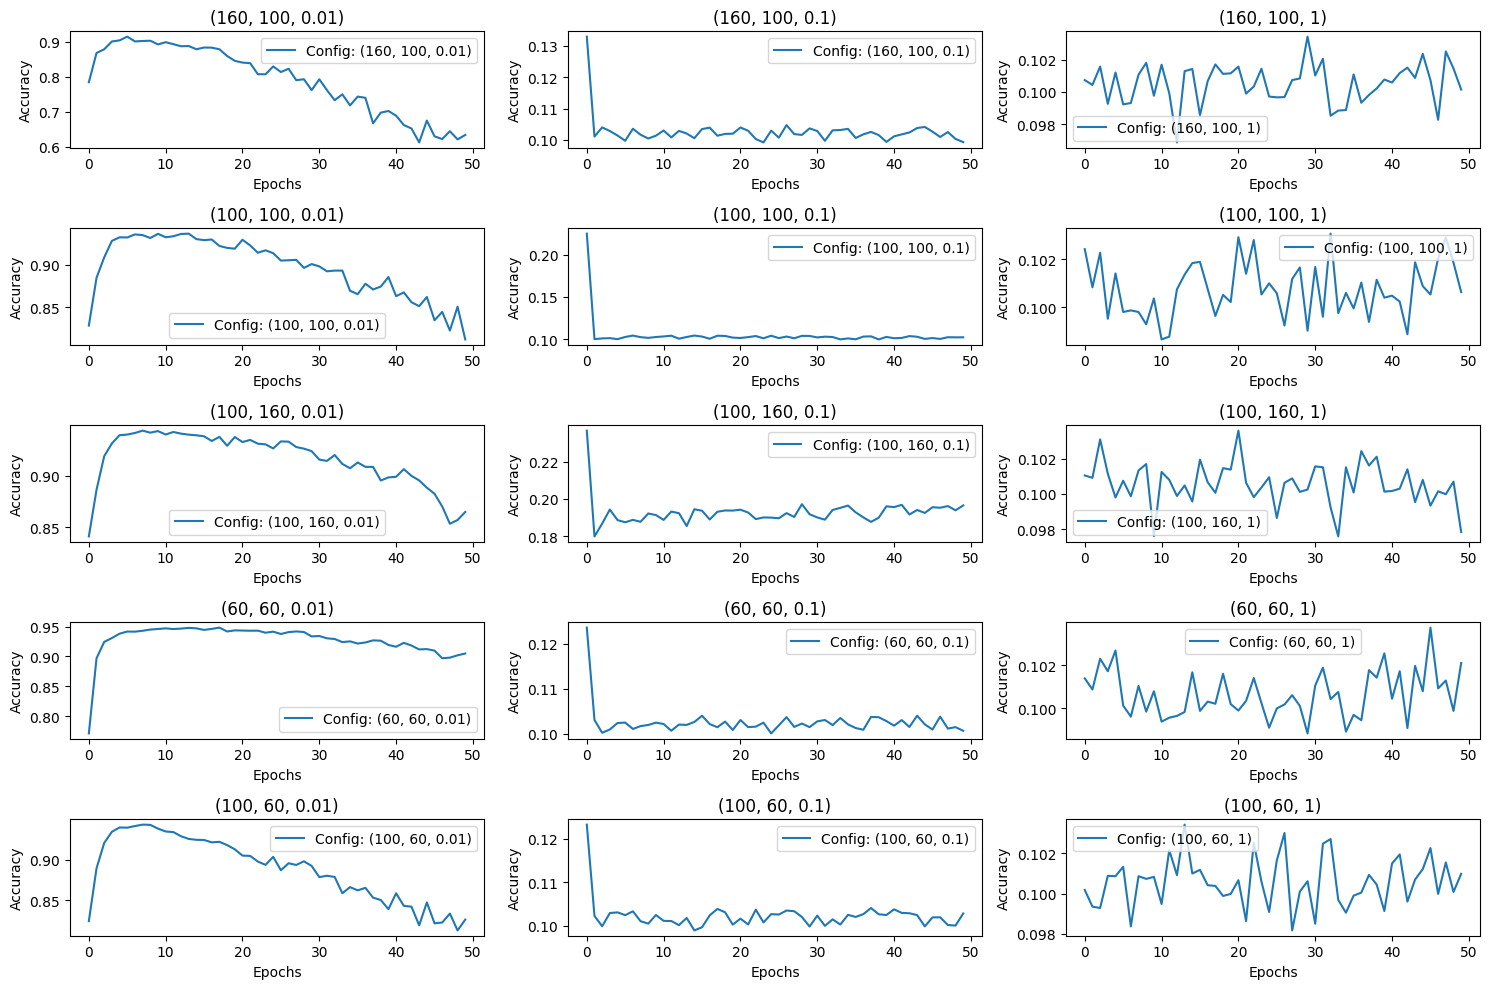

In [13]:
# Plot Accuracy Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(accuracy_curves.keys()):
    plt.subplot(5, 3, i + 1)
    plt.plot(accuracy_curves[key], label=f"Config: {key}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{key}")
    plt.legend()
plt.tight_layout()
plt.show()
print()

Loss Curves

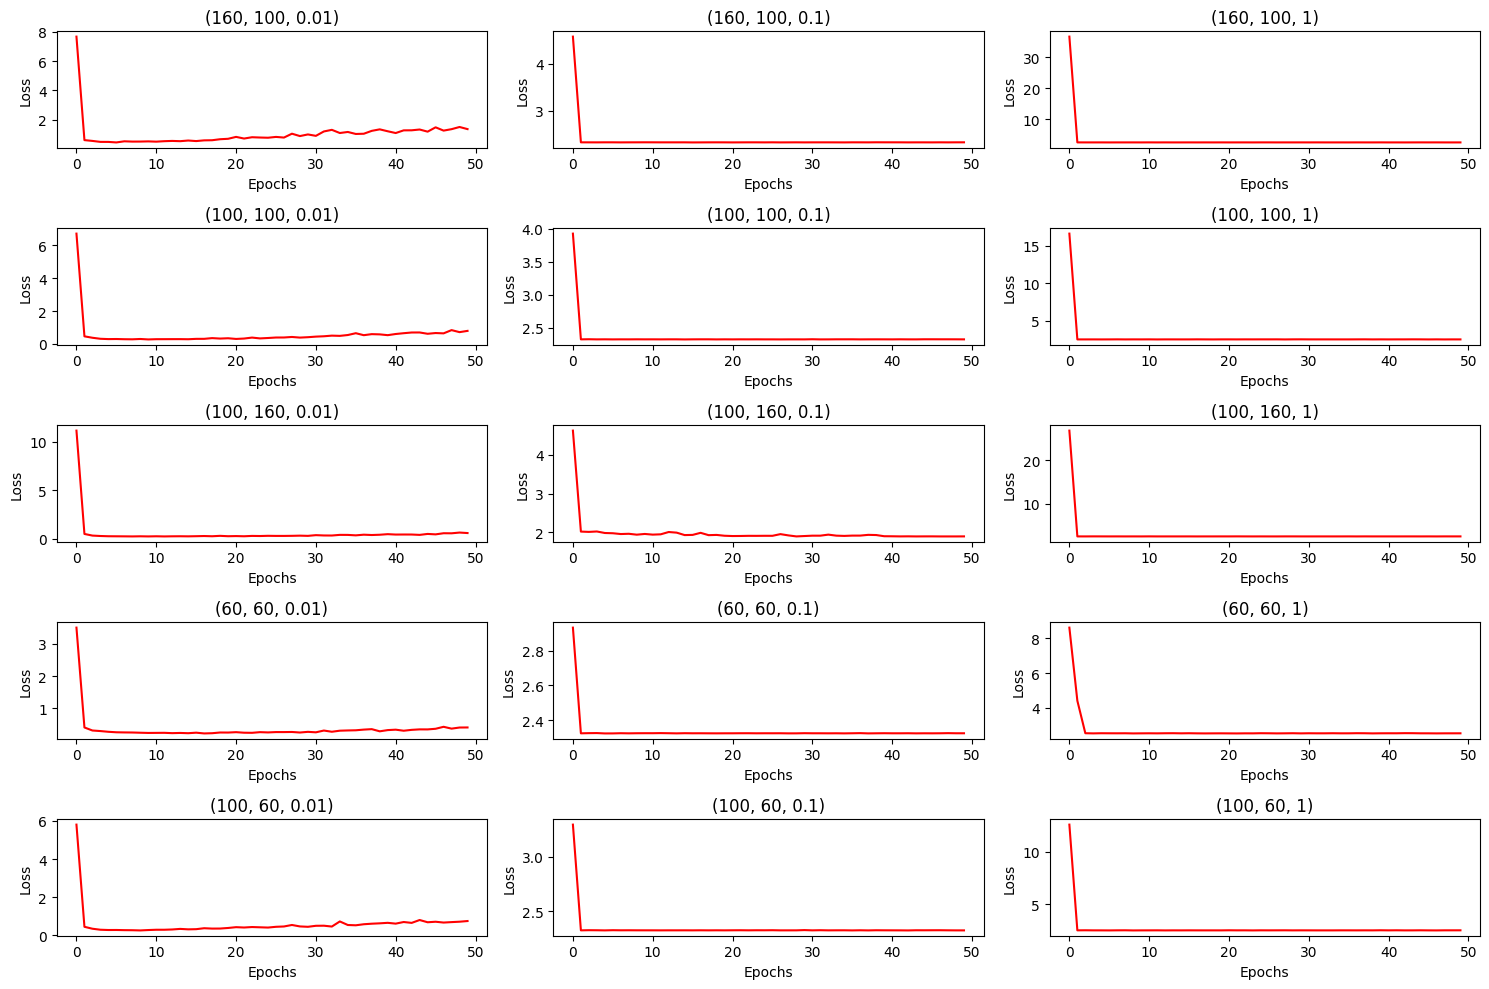

In [14]:
# Plot Loss Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(loss_curves.keys()):
    plt.subplot(5, 3, i + 1)
    plt.plot(loss_curves[key], label=f"Config: {key}", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{key}")
    # plt.legend()
plt.tight_layout()
plt.show()
print()

Confusion Matrices

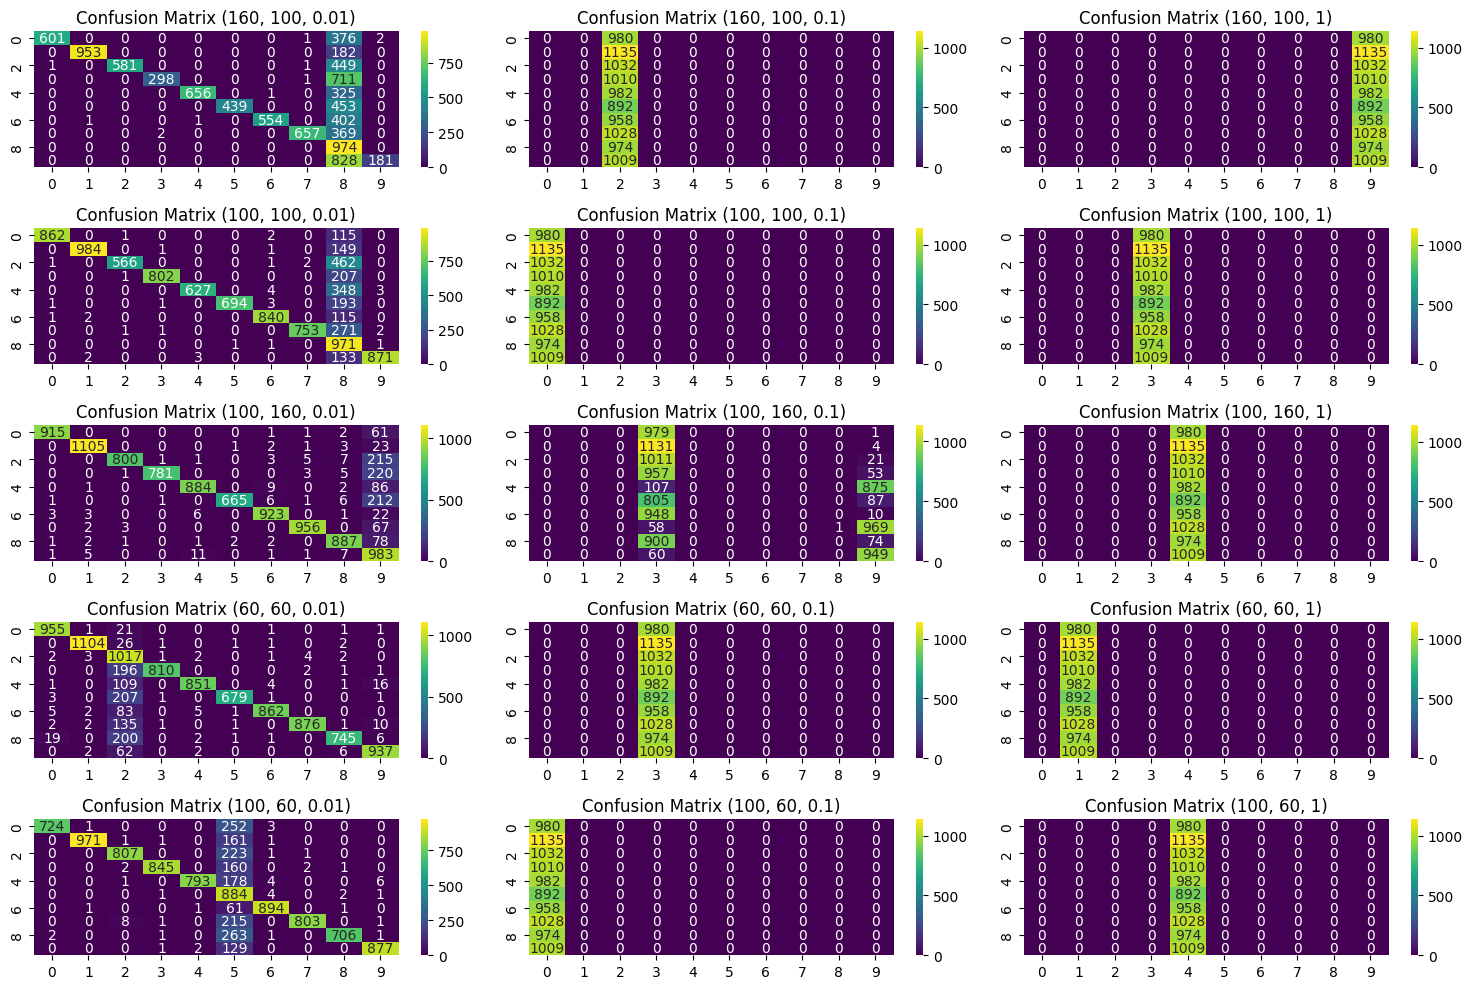

In [15]:
# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, key in enumerate(confusion_matrices.keys()):
    plt.subplot(5, 3, i + 1)
    sns.heatmap(confusion_matrices[key], annot=True, cmap="viridis", fmt='d')
    plt.title(f"Confusion Matrix {key}")
plt.tight_layout()
plt.show()
print()

- **Accuracy Curves:** The model's accuracy is computed for different hyperparameter settings.
- **Loss Curve:** Used to monitor convergence and model stability over epochs.
- **Confusion Matrix:** Used to analyze classification errors.


### **6. My Comments (Limitations and Scope for Improvement)**
1. **Limitations:**
   - As we can see that the convergence is reached faster when neurons of hidden layer is increased but after certain epochs the accuracy again starts degrading
   - Fixed batch size may not be optimal for all configurations.
   - The training time is high due to a combination of large epochs and a small batch size.
   - Large learning rate reduces the accuracy and for slow learning rates it takes more time to reach at point of convergence.
2. **Scope for Improvement:**
   - Tuning other hyperparameters like batch size and optimizer along with different parameter can give better results.
   - Use of CNN architectures over BPNN can give better results.


